## **EV County Population vs Population Density per County**

# **Introduction on my RDB**

Some background information from my RDB, I created my primary key which is the "id" column in all of my tables. The foreign key is the counties, which matches all of the tables.

**Some simple questions and answers:** **bold text**

**What questions/types of questions will you be able to answer?**

With this RDB I plan on being able to give easy access to data scientists to be able to query the data to make inferences, this can be examples of how population can effect the EV population, as well as how the EV population has increased as well as the population increased. Have they increased together? Is there a correlation?

**What can your RDB be used for, who would the end user be?**

The end user will hopefully be data scientists looking to make correlations and are interested in the data from the counties in the state of Washington. The datasets have a ton of information such as the population estimates per county, as well as the EV statistics per county for every month up to 2023.

**Here are some links to datasets that were used to create the RDB.**

EV Statistics per County in Washington: https://catalog.data.gov/dataset/electric-vehicle-population-size-history-by-county

County Population Statistics 2010-2020: https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/

County Population Statistics 2020-2022, just click on "Washington" and it will give you the download: https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html

**What resides in each dataset?**

In the EV Statistics dataset, it shows the EV statistics per county for each month from 2017-2023. This dataset is very useful as it also branches out to each type of EV and the amounts within. It also shows the statistics for trucks and cars but I ended up just combining the two as I believe data scientists would be more interested in the amount of ev's and not which type of vehicle are evs.

The second and third datasets are self explanatory, it has the population estimates for the years 2010-2023, with a simple merge I was able to combine those two datasets to make it seem like it is just one large dataset.

**Finally, here is the finished product RDB Schema, as you can see the 'id' is the primary key while the foreign key are the Counties.**

**What is ETL?**

E = Extract: Taking data from different sources.

T = Transform: Cleaning and manipulating the data to make it suffice.

L = Load: Loading all of the data into the target system.

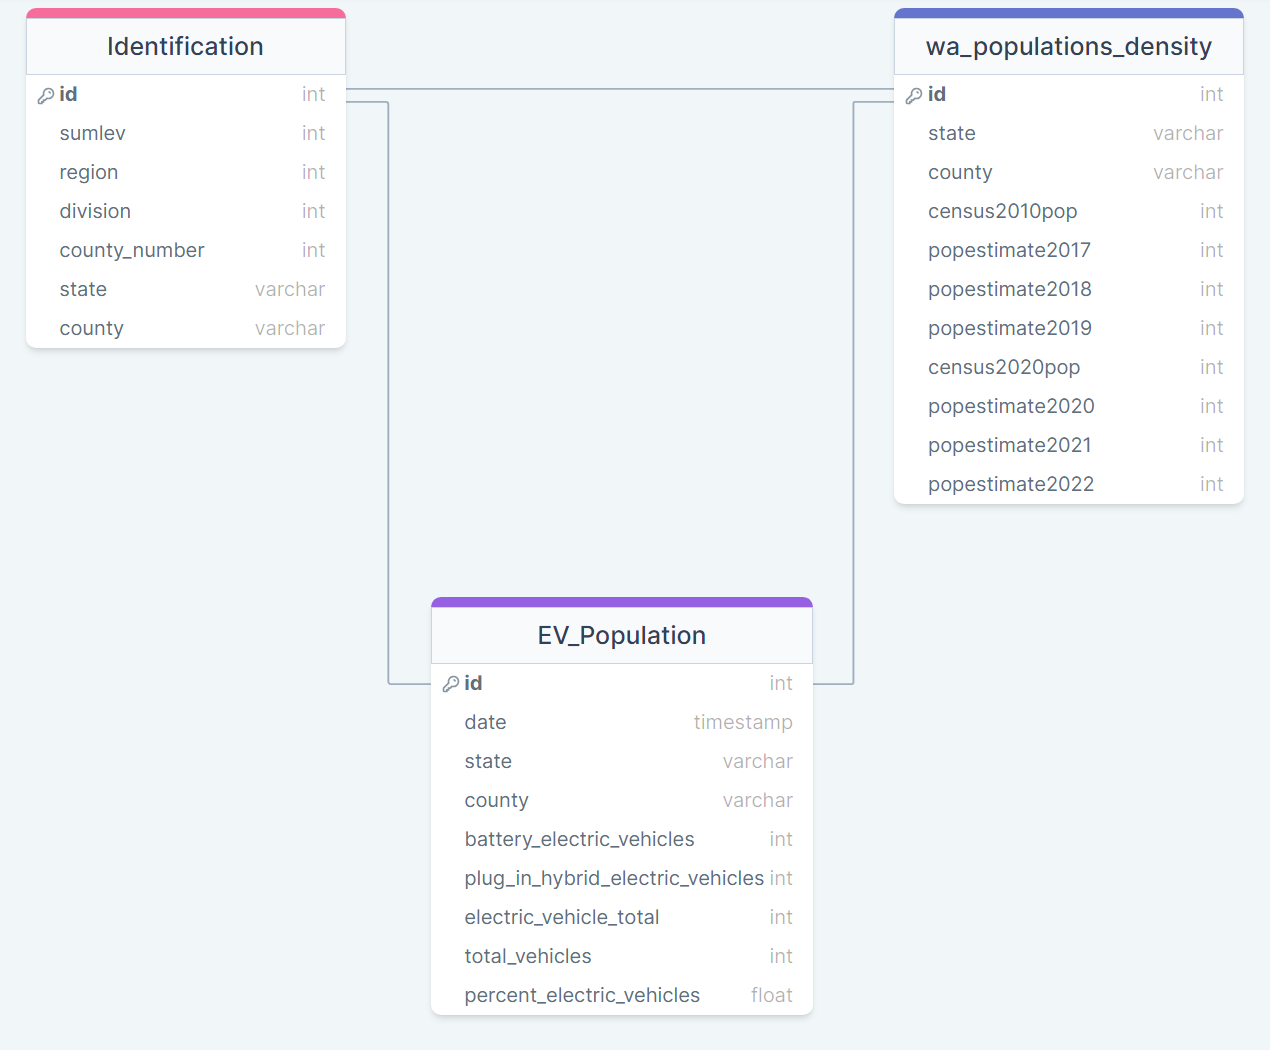


# Libraries and Given SQL Functions

In [525]:
# Loading Libraries
import pandas as pd
import psycopg2
import numpy as np

In [526]:
# Make our connection/cursor function
def get_conn_cur(): # define function name and arguments (there aren't any)
  # Make a connection
  conn = psycopg2.connect(
    host="test-hw-db.cvzqbbmb3i8b.us-east-2.rds.amazonaws.com",
    database="hw3_db",
    user="postgres",
    password="Rc23724170!!",
    port='5432')

  cur = conn.cursor()   # Make a cursor after

  return(conn, cur)   # Return both the connection and the cursor

def run_query(query_string):

 conn, cur = get_conn_cur() # get connection and cursor

 cur.execute(query_string) # executing string as before

 my_data = cur.fetchall() # fetch query data as before

 # here we're extracting the 0th element for each item in cur.description
 colnames = [desc[0] for desc in cur.description]

 cur.close() # close
 conn.close() # close

 return(colnames, my_data) # return column names AND data

# Column name function for checking out what's in a table
def get_column_names(table_name): # arguement of table_name
 conn, cur = get_conn_cur() # get connection and cursor

 # Now select column names while inserting the table name into the WERE
 column_name_query = """SELECT column_name FROM information_schema.columns
    WHERE table_name = '%s' """ %table_name

 cur.execute(column_name_query) # exectue
 my_data = cur.fetchall() # store

 cur.close() # close
 conn.close() # close

 return(my_data) # return

# Check table_names
def get_table_names():
  conn, cur = get_conn_cur() # get connection and cursor

  # query to get table names
  table_name_query = """SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public' """

  cur.execute(table_name_query) # execute
  my_data = cur.fetchall() # fetch results

  cur.close() #close cursor
  conn.close() # close connection

  return(my_data) # return your fetched results

# make sql_head function
def sql_head(table_name):
 conn, cur = get_conn_cur() # get connection and cursor

 # Now select column names while inserting the table name into the WERE
 head_query = """SELECT * FROM %s LIMIT 5; """ %table_name

 cur.execute(head_query) # exectue
 colnames = [desc[0] for desc in cur.description] # get column names
 my_data = cur.fetchall() # store first five rows

 cur.close() # close
 conn.close() # close

 df = pd.DataFrame(data = my_data, columns = colnames) # make into df

 return(df) # return

# drop a table from your rdb (if you try to create a table that already exists, it'll throw an error)
def my_drop_table(tab_name):
  conn, cur = get_conn_cur()
  tq = """DROP TABLE IF EXISTS %s CASCADE;""" %tab_name
  cur.execute(tq)
  conn.commit()

# Extract

In [527]:
# Bringing in the data
EV_Pop = pd.read_csv("https://data.wa.gov/api/views/3d5d-sdqb/rows.csv?accessType=DOWNLOAD")
county_stats_2010_to_2020 = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv", encoding = 'latin1')
county_pop_20_22 = pd.read_excel("https://www2.census.gov/programs-surveys/popest/tables/2020-2022/counties/totals/co-est2022-pop-53.xlsx")

In [528]:
# Exploring the Data, getting count of rows, data types, count of columns.
EV_Pop.dtypes

Date                                         object
County                                       object
State                                        object
Vehicle Primary Use                          object
Battery Electric Vehicles (BEVs)              int64
Plug-In Hybrid Electric Vehicles (PHEVs)      int64
Electric Vehicle (EV) Total                   int64
Non-Electric Vehicle Total                    int64
Total Vehicles                                int64
Percent Electric Vehicles                   float64
dtype: object

In [529]:
# Length of Rows
len(EV_Pop.index)

19429

In [530]:
# Length of Columns
len(EV_Pop.columns)

10

In [531]:
# Getting information on Population
EV_Pop.describe

<bound method NDFrame.describe of                    Date     County State Vehicle Primary Use  \
0         April 30 2018    Alameda    CA           Passenger   
1         March 31 2021       Kern    CA           Passenger   
2      February 29 2020   Kootenai    ID           Passenger   
3      February 28 2021       Polk    FL           Passenger   
4         April 30 2022  Frederick    MD           Passenger   
...                 ...        ...   ...                 ...   
19424       May 31 2020     Queens    NY           Passenger   
19425     April 30 2023    Harnett    NC           Passenger   
19426     April 30 2021     Rogers    OK           Passenger   
19427      July 31 2019      Boone    MO           Passenger   
19428  November 30 2021   Skamania    WA               Truck   

       Battery Electric Vehicles (BEVs)  \
0                                     0   
1                                     0   
2                                     1   
3                        

In [532]:
# Checking first five rows.
EV_Pop.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,April 30 2018,Alameda,CA,Passenger,0,1,1,356,357,0.28
1,March 31 2021,Kern,CA,Passenger,0,1,1,216,217,0.46
2,February 29 2020,Kootenai,ID,Passenger,1,1,2,228,230,0.87
3,February 28 2021,Polk,FL,Passenger,1,0,1,58,59,1.69
4,April 30 2022,Frederick,MD,Passenger,1,1,2,70,72,2.78


In [533]:
# Checking last five rows.
EV_Pop.tail()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
19424,May 31 2020,Queens,NY,Passenger,1,0,1,52,53,1.89
19425,April 30 2023,Harnett,NC,Passenger,4,0,4,132,136,2.94
19426,April 30 2021,Rogers,OK,Passenger,1,0,1,3,4,25.00
19427,July 31 2019,Boone,MO,Passenger,0,1,1,10,11,9.09
19428,November 30 2021,Skamania,WA,Truck,0,0,0,4000,4000,0.00


# Transform

In [534]:
# Obviously we see that we need to change the date column to datetime.
EV_Pop["Date"] = pd.to_datetime(EV_Pop['Date'])

In [535]:
# Replacing WA abbreviation to full state name.
EV_Pop["State"] = EV_Pop["State"].replace('WA', 'Washington')

In [536]:
# Filtering for only values that have Washington.
EV_WA_Pop = EV_Pop[EV_Pop['State'] == 'Washington']

In [537]:
# Checking New Data Frame filtered for Washington State
EV_WA_Pop

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
7,2022-08-31,Adams,Washington,Passenger,21,9,30,12960,12990,0.23
8,2022-04-30,Grant,Washington,Truck,0,0,0,28075,28075,0.00
13,2017-07-31,Grant,Washington,Passenger,19,30,49,61003,61052,0.08
14,2022-11-30,Ferry,Washington,Passenger,24,4,28,4367,4395,0.64
19,2023-08-31,Snohomish,Washington,Passenger,13916,3209,17125,523125,540250,3.17
...,...,...,...,...,...,...,...,...,...,...
19416,2021-07-31,Yakima,Washington,Truck,0,0,0,61715,61715,0.00
19419,2022-07-31,Okanogan,Washington,Passenger,88,49,137,26289,26426,0.52
19420,2020-06-30,Asotin,Washington,Passenger,16,12,28,12318,12346,0.23
19422,2017-05-31,Lewis,Washington,Truck,0,0,0,24825,24825,0.00


In [538]:
# Looking at my data for an example county to see how it's looking
EV_WA_Pop[EV_WA_Pop['County'] == 'Lewis']

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
53,2017-08-31,Lewis,Washington,Truck,0,0,0,25015,25015,0.00
180,2023-04-30,Lewis,Washington,Passenger,301,197,498,58863,59361,0.84
214,2017-01-31,Lewis,Washington,Truck,0,0,0,24794,24794,0.00
418,2020-07-31,Lewis,Washington,Passenger,107,115,222,58129,58351,0.38
539,2022-01-31,Lewis,Washington,Truck,0,0,0,26649,26649,0.00
...,...,...,...,...,...,...,...,...,...,...
18762,2020-02-29,Lewis,Washington,Passenger,108,105,213,59571,59784,0.36
19170,2021-12-31,Lewis,Washington,Truck,0,0,0,26671,26671,0.00
19306,2020-04-30,Lewis,Washington,Truck,0,0,0,25980,25980,0.00
19414,2020-08-31,Lewis,Washington,Passenger,112,117,229,58201,58430,0.39


In [539]:
# Making it in order By Date.
EV_WA_Pop = EV_WA_Pop.sort_values('Date', ascending = True)
EV_WA_Pop

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
14317,2017-01-31,Pend Oreille,Washington,Passenger,1,4,5,9344,9349,0.05
6456,2017-01-31,Spokane,Washington,Truck,1,0,1,90424,90425,0.00
18008,2017-01-31,Grant,Washington,Truck,0,0,0,25039,25039,0.00
6263,2017-01-31,Thurston,Washington,Passenger,336,299,635,184939,185574,0.34
14150,2017-01-31,Whitman,Washington,Truck,0,0,0,8404,8404,0.00
...,...,...,...,...,...,...,...,...,...,...
8552,2023-10-31,Whatcom,Washington,Passenger,2767,963,3730,143370,147100,2.54
18264,2023-10-31,Jefferson,Washington,Truck,13,0,13,9062,9075,0.14
14536,2023-10-31,Grant,Washington,Truck,11,0,11,27062,27073,0.04
5576,2023-10-31,Adams,Washington,Passenger,29,12,41,12602,12643,0.32


In [540]:
# I see that there are Duplicates for counties and dates because of the difference between passenger and truck.
# I don't think data scientists would care if it's a truck or a car, and it just makes the data set a cluttered mess so I will merge the two and sum toughether the values

EV_WA_Pop = EV_WA_Pop.groupby(['Date','County']).sum().reset_index()

<ipython-input-540-9ab7d1e434a0>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  EV_WA_Pop = EV_WA_Pop.groupby(['Date','County']).sum().reset_index()


In [541]:
# Checking to see if that worked, and it did. This got rid of a ton of zero values as most of the Truck types had zero EV's making the data way too large and redundant.
EV_WA_Pop

,Date,County,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2017-01-31,Adams,1,1,2,17251,17253,0.02
1,2017-01-31,Asotin,4,3,7,18805,18812,0.06
2,2017-01-31,Benton,129,129,258,167661,167919,0.20
3,2017-01-31,Chelan,54,28,82,73160,73242,0.16
4,2017-01-31,Clallam,73,64,137,69042,69179,0.28
...,...,...,...,...,...,...,...,...
3193,2023-10-31,Wahkiakum,32,20,52,4678,4730,1.82
3194,2023-10-31,Walla Walla,257,126,383,47708,48091,1.13
3195,2023-10-31,Whatcom,2842,963,3805,184449,188254,2.72
3196,2023-10-31,Whitman,188,92,280,29839,30119,1.33


In [542]:
# Investigating other Dataset with Datatypes.
county_stats_2010_to_2020.dtypes

SUMLEV                int64
REGION                int64
DIVISION              int64
STATE                 int64
COUNTY                int64
STNAME               object
CTYNAME              object
CENSUS2010POP        object
ESTIMATESBASE2010     int64
POPESTIMATE2010       int64
POPESTIMATE2011       int64
POPESTIMATE2012       int64
POPESTIMATE2013       int64
POPESTIMATE2014       int64
POPESTIMATE2015       int64
POPESTIMATE2016       int64
POPESTIMATE2017       int64
POPESTIMATE2018       int64
POPESTIMATE2019       int64
POPESTIMATE042020     int64
POPESTIMATE2020       int64
dtype: object

In [543]:
# Grabbing first 5 rows to investigate Data Frame
county_stats_2010_to_2020.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54970,54747,54922,54903,55302,55448,55533,55769,56130,56145
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,190203,194978,199306,203101,207787,212737,218071,223565,227989,229287
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,27172,26946,26768,26300,25828,25169,24887,24657,24652,24589
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22657,22510,22541,22553,22590,22532,22300,22313,22199,22136


In [544]:
# Grabbing last five rows to investigate data frame.
county_stats_2010_to_2020.tail()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,45032,45189,44996,44780,44319,43663,43188,42917,42717,42673
3190,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,21643,22335,22801,23083,23255,23383,23261,23385,23453,23497
3191,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,21008,20969,20835,20777,20711,20449,20299,20196,20169,20215
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,8410,8417,8277,8282,8180,8013,7886,7824,7756,7760
3193,50,4,8,56,45,Wyoming,Weston County,7208,7208,7198,...,7075,7132,7134,7202,7228,6962,6895,6880,6752,6743


In [545]:
# Dropping Collumns that are irrelevant, such as dates that are out of range with my other dataset.
county_stats_2010_to_2020 = county_stats_2010_to_2020.drop(['ESTIMATESBASE2010', 'POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016'], axis = 1)

In [546]:
# Changing names to match Other Datasets
county_stats_2010_to_2020 = county_stats_2010_to_2020.rename(columns={'CTYNAME': 'County', 'COUNTY': 'County_Number', 'STNAME': 'State', 'STATE': 'STATE_ID'})

In [547]:
# Checking Changes to Column Names
county_stats_2010_to_2020

,SUMLEV,REGION,DIVISION,STATE_ID,County_Number,State,County,CENSUS2010POP,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
0,40,3,6,1,0,Alabama,Alabama,4779736,4877989,4891628,4907965,4920706,4921532
1,50,3,6,1,1,Alabama,Autauga County,54571,55448,55533,55769,56130,56145
2,50,3,6,1,3,Alabama,Baldwin County,182265,212737,218071,223565,227989,229287
3,50,3,6,1,5,Alabama,Barbour County,27457,25169,24887,24657,24652,24589
4,50,3,6,1,7,Alabama,Bibb County,22915,22532,22300,22313,22199,22136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43663,43188,42917,42717,42673
3190,50,4,8,56,39,Wyoming,Teton County,21294,23383,23261,23385,23453,23497
3191,50,4,8,56,41,Wyoming,Uinta County,21118,20449,20299,20196,20169,20215
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8013,7886,7824,7756,7760


In [548]:
# Filtering down to only counties in Washington State.
county_stats_2010_to_2020 = county_stats_2010_to_2020[county_stats_2010_to_2020['State'] == 'Washington']


In [549]:
# Checking to see if the length is right and I see we're one over, and thats because they have Washington, Washington as the total population estimate for the state.
len(county_stats_2010_to_2020.index)

40

In [550]:
# Removing total state population as we are only worried about population data per county.
county_stats_2010_to_2020 = county_stats_2010_to_2020.drop(county_stats_2010_to_2020[county_stats_2010_to_2020['County'] == 'Washington'].index)

In [551]:
# Getting rid of the word county to make it match the other Data frame
county_stats_2010_to_2020['County'] = county_stats_2010_to_2020['County'].str.replace('County',"")

In [552]:
# Checking to see if County words were removed.
county_stats_2010_to_2020

,SUMLEV,REGION,DIVISION,STATE_ID,County_Number,State,County,CENSUS2010POP,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
3002,50,4,9,53,1,Washington,Adams,18728,19574,19640,19959,20052,20027
3003,50,4,9,53,3,Washington,Asotin,21623,22612,22699,22687,22812,22820
3004,50,4,9,53,5,Washington,Benton,175177,198229,201174,204173,206007,206426
3005,50,4,9,53,7,Washington,Chelan,72453,76216,76612,77053,77498,77574
3006,50,4,9,53,9,Washington,Clallam,71404,75741,76792,77457,77979,78067
3007,50,4,9,53,11,Washington,Clark,425363,475238,482467,489271,495223,496865
3008,50,4,9,53,13,Washington,Columbia,4078,4010,4055,4023,4045,4048
3009,50,4,9,53,15,Washington,Cowlitz,102410,106800,108673,110389,111187,111371
3010,50,4,9,53,17,Washington,Douglas,38431,41961,42518,43251,43538,43560
3011,50,4,9,53,19,Washington,Ferry,7551,7587,7661,7676,7763,7759


In [553]:
# Looking at an Example with county filtered.
EV_WA_Pop[EV_WA_Pop['County'] == 'Lewis']

,Date,County,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
20,2017-01-31,Lewis,43,30,73,79755,79828,0.13
59,2017-02-28,Lewis,45,31,76,79757,79833,0.14
98,2017-03-31,Lewis,45,34,79,79912,79991,0.14
137,2017-04-30,Lewis,46,33,79,79992,80071,0.14
176,2017-05-31,Lewis,49,33,82,80188,80270,0.15
...,...,...,...,...,...,...,...,...
3023,2023-06-30,Lewis,336,210,546,85130,85676,0.93
3062,2023-07-31,Lewis,342,221,563,84949,85512,0.96
3101,2023-08-31,Lewis,351,251,602,84488,85090,1.03
3140,2023-09-30,Lewis,366,272,638,83736,84374,1.10


In [554]:
# Dropping these indexes because it had random title and information from an excel title that was not included in the dataset. The format isn't csv as it is an xsl file. This made formatting really weird. This was just the title of the spreadsheet.
county_pop_20_22 = county_pop_20_22.drop(index=range(4))

In [555]:
# Checking to see if redundant information was dropped.
county_pop_20_22

,table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
4,".Adams County, Washington",20612,20608,20640.0,20961.0
5,".Asotin County, Washington",22288,22325,22468.0,22508.0
6,".Benton County, Washington",206875,207413,210585.0,212791.0
7,".Chelan County, Washington",79078,79228,79775.0,79926.0
8,".Clallam County, Washington",77160,77357,78442.0,77805.0
9,".Clark County, Washington",503309,505301,512588.0,516779.0
10,".Columbia County, Washington",3952,3949,4015.0,4026.0
11,".Cowlitz County, Washington",110740,111019,111648.0,111956.0
12,".Douglas County, Washington",42937,43031,43838.0,44192.0
13,".Ferry County, Washington",7178,7196,7267.0,7448.0


In [556]:
# Renaming the dataset as it is very messy because the excel file does not port well with pandas.
county_pop_20_22 = county_pop_20_22.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)': 'County', 'Unnamed: 1': 'CENSUS2020POP', 'Unnamed: 2': 'POPESTIMATE2020', 'Unnamed: 3': 'POPESTIMATE2021', 'Unnamed: 4': 'POPESTIMATE2022'})

In [557]:
# Dropping last 5 collumns as it is not important data and was imported through excel file.
county_pop_20_22 = county_pop_20_22.drop(index=county_pop_20_22.index[-5:])

In [558]:
# Making it match the other datasets, dropping the word county.
county_pop_20_22['County'] = county_pop_20_22['County'].str.replace('County',"")

In [559]:
# Dropping the comma and
county_pop_20_22['County'] = county_pop_20_22['County'].str.replace(' , Washington',"")

In [560]:
# Getting rid of the messy period before the Counties.
county_pop_20_22['County'] = county_pop_20_22['County'].str.replace('.',"")

<ipython-input-560-5a1c4b6ac2f4>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  county_pop_20_22['County'] = county_pop_20_22['County'].str.replace('.',"")


In [561]:
# Stripping the empty space between county, took me days to figure out why it wasn't merging and there was a space after each county.
county_stats_2010_to_2020['County'] = county_stats_2010_to_2020['County'].apply(lambda x: x.strip())

In [562]:
# Merging the Population Estimates from 2010-2020, and 2020-2022.
Pop_Estimates_Merged = pd.merge(county_pop_20_22, county_stats_2010_to_2020, on =['County'], how='left')

In [563]:
# Merging the EV Dataframe with Population Estimates.
EV_Pop_Estimates_Merged = pd.merge(EV_WA_Pop, Pop_Estimates_Merged, on =['County'], how='left')

In [564]:
# Changing names to remove three-four word column names, also removing the dashes and parenthasees as it gave the SQL trouble when creating the tables.
EV_Pop_Estimates_Merged = EV_Pop_Estimates_Merged.rename(columns={'Battery Electric Vehicles (BEVs)': 'Battery_Electric_Vehicles', 'Plug-In Hybrid Electric Vehicles (PHEVs)': 'Plug_In_Hybrid_Electric_Vehicles', 'Electric Vehicle (EV) Total': 'Electric_Vehicle_Total', 'Total Vehicles': 'Total_Vehicles', 'Percent Electric Vehicles': 'Percent_Electric_Vehicles'})

In [565]:
# Dropping the POPESTIMATE2020 from the 2010 dataset, as I have an updated estimate from the CENSUS 2020.
EV_Pop_Estimates_Merged = EV_Pop_Estimates_Merged.drop(columns = ['POPESTIMATE2020_y'])

In [566]:
# Renaming the POPESTIMATE2020_x back to POPESTIMATE2020
# Changing names to remove three-four word column names, also removing the dashes and parenthasees as it gave the SQL trouble when creating the tables.
EV_Pop_Estimates_Merged = EV_Pop_Estimates_Merged.rename(columns={'POPESTIMATE2020_x': 'POPESTIMATE2020', 'Battery Electric Vehicles (BEVs)': 'Battery_Electric_Vehicles', 'Plug-In Hybrid Electric Vehicles (PHEVs)': 'Plug_In_Hybrid_Electric_Vehicles', 'Electric Vehicle (EV) Total': 'Electric_Vehicle_Total', 'Total Vehicles': 'Total_Vehicles', 'Percent Electric Vehicles': 'Percent_Electric_Vehicles'})

In [567]:
# Creating a primary key as all tables need one.
EV_Pop_Estimates_Merged.insert(0, 'id', range(1, len(EV_Pop_Estimates_Merged) + 1))

In [568]:
# Checking the merged dataframe.
EV_Pop_Estimates_Merged

,id,Date,County,Battery_Electric_Vehicles,Plug_In_Hybrid_Electric_Vehicles,Electric_Vehicle_Total,Non-Electric Vehicle Total,Total_Vehicles,Percent_Electric_Vehicles,CENSUS2020POP,...,REGION,DIVISION,STATE_ID,County_Number,State,CENSUS2010POP,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020
0,1,2017-01-31,Adams,1,1,2,17251,17253,0.02,20612,...,4,9,53,1,Washington,18728,19574,19640,19959,20052
1,2,2017-01-31,Asotin,4,3,7,18805,18812,0.06,22288,...,4,9,53,3,Washington,21623,22612,22699,22687,22812
2,3,2017-01-31,Benton,129,129,258,167661,167919,0.20,206875,...,4,9,53,5,Washington,175177,198229,201174,204173,206007
3,4,2017-01-31,Chelan,54,28,82,73160,73242,0.16,79078,...,4,9,53,7,Washington,72453,76216,76612,77053,77498
4,5,2017-01-31,Clallam,73,64,137,69042,69179,0.28,77160,...,4,9,53,9,Washington,71404,75741,76792,77457,77979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,3194,2023-10-31,Wahkiakum,32,20,52,4678,4730,1.82,4419,...,4,9,53,69,Washington,3978,4207,4343,4420,4483
3194,3195,2023-10-31,Walla Walla,257,126,383,47708,48091,1.13,62586,...,4,9,53,71,Washington,58781,60683,60778,61062,61259
3195,3196,2023-10-31,Whatcom,2842,963,3805,184449,188254,2.72,226843,...,4,9,53,73,Washington,201140,221417,225098,228675,230501
3196,3197,2023-10-31,Whitman,188,92,280,29839,30119,1.33,47971,...,4,9,53,75,Washington,44776,49514,49821,50136,49664


In [569]:
# Changing datatypes from object or float to int as it is integer numbers and not a string.
EV_Pop_Estimates_Merged['CENSUS2020POP'] = EV_Pop_Estimates_Merged['CENSUS2020POP'].astype(int)
EV_Pop_Estimates_Merged['POPESTIMATE2020'] = EV_Pop_Estimates_Merged['POPESTIMATE2020'].astype(int)
EV_Pop_Estimates_Merged['POPESTIMATE2021'] = EV_Pop_Estimates_Merged['POPESTIMATE2021'].astype(int)
EV_Pop_Estimates_Merged['POPESTIMATE2022'] = EV_Pop_Estimates_Merged['POPESTIMATE2022'].astype(int)
EV_Pop_Estimates_Merged['CENSUS2010POP'] = EV_Pop_Estimates_Merged['CENSUS2010POP'].astype(int)

# Load

In [570]:
# Creating my first table
identifications = EV_Pop_Estimates_Merged[['id','SUMLEV','REGION','DIVISION','STATE_ID','County_Number','State','County']]

In [571]:
my_drop_table('identification')

In [572]:
tq = """ CREATE TABLE identification (
  id INT NOT NULL,
  SUMLEV INT NOT NULL,
  REGION INT NOT NULL,
  DIVISION INT NOT NULL,
  STATE_ID INT NOT NULL,
  County_Number INT NOT NULL,
  State VARCHAR(255) NOT NULL,
  County VARCHAR(255) NOT NULL
  );"""

In [573]:
conn, cur = get_conn_cur()
cur.execute(tq)
conn.commit()

In [574]:
rollup_tuples = identifications.to_numpy();
rollup_tuples[:,1] = np.vectorize(lambda x: str(x))(rollup_tuples[:,1])
data_tupls = [tuple(x) for x in rollup_tuples]

In [575]:
iq = """INSERT INTO identification(id, sumlev, region, division, state_id, county_number, state, county) VALUES(%s, %s, %s, %s, %s, %s, %s, %s);"""

In [576]:
#Execute the string
conn, cur = get_conn_cur()
cur.executemany(iq, data_tupls)
#Commit and check
conn.commit()
conn.close()

In [577]:
# Checking the table
sql_head('identification')

,id,sumlev,region,division,state_id,county_number,state,county
0,1,50,4,9,53,1,Washington,Adams
1,2,50,4,9,53,3,Washington,Asotin
2,3,50,4,9,53,5,Washington,Benton
3,4,50,4,9,53,7,Washington,Chelan
4,5,50,4,9,53,9,Washington,Clallam


In [578]:
# Creating my second table
EV_Per_County = EV_Pop_Estimates_Merged[['id', 'Date', 'State', 'County', 'Battery_Electric_Vehicles', 'Plug_In_Hybrid_Electric_Vehicles', 'Electric_Vehicle_Total', 'Total_Vehicles', 'Percent_Electric_Vehicles']]

In [579]:
my_drop_table('EV_Population')

In [580]:
# Verifying datatypes
EV_Pop_Estimates_Merged.dtypes

id                                           int64
Date                                datetime64[ns]
County                                      object
Battery_Electric_Vehicles                    int64
Plug_In_Hybrid_Electric_Vehicles             int64
Electric_Vehicle_Total                       int64
Non-Electric Vehicle Total                   int64
Total_Vehicles                               int64
Percent_Electric_Vehicles                  float64
CENSUS2020POP                                int64
POPESTIMATE2020                              int64
POPESTIMATE2021                              int64
POPESTIMATE2022                              int64
SUMLEV                                       int64
REGION                                       int64
DIVISION                                     int64
STATE_ID                                     int64
County_Number                                int64
State                                       object
CENSUS2010POP                  

In [581]:
tq = """ CREATE TABLE EV_Population (
  id INT NOT NULL,
  Date TIMESTAMP NOT NULL,
  State VARCHAR(255) NOT NULL,
  County VARCHAR(255) NOT NULL,
  Battery_Electric_Vehicles INT NOT NULL,
  Plug_In_Hybrid_Electric_Vehicles INT NOT NULL,
  Electric_Vehicle_Total INT NOT NULL,
  Total_Vehicles INT NOT NULL,
  Percent_Electric_Vehicles FLOAT NOT NULL
  );"""

In [582]:
conn, cur = get_conn_cur()
cur.execute(tq)
conn.commit()

In [583]:
rollup_tuples = EV_Per_County.to_numpy();
rollup_tuples[:,1] = np.vectorize(lambda x: str(x))(rollup_tuples[:,1])
data_tupls = [tuple(x) for x in rollup_tuples]

In [584]:
iq = """INSERT INTO EV_Population(id, Date, State, County, Battery_Electric_Vehicles, Plug_In_Hybrid_Electric_Vehicles, Electric_Vehicle_Total, Total_Vehicles, Percent_Electric_Vehicles) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s);"""

In [585]:
#Execute the string
conn, cur = get_conn_cur()
cur.executemany(iq, data_tupls)
#Commit and check
conn.commit()
conn.close()

In [586]:
sql_head('EV_Population')

,id,date,state,county,battery_electric_vehicles,plug_in_hybrid_electric_vehicles,electric_vehicle_total,total_vehicles,percent_electric_vehicles
0,1,2017-01-31,Washington,Adams,1,1,2,17253,0.02
1,2,2017-01-31,Washington,Asotin,4,3,7,18812,0.06
2,3,2017-01-31,Washington,Benton,129,129,258,167919,0.20
3,4,2017-01-31,Washington,Chelan,54,28,82,73242,0.16
4,5,2017-01-31,Washington,Clallam,73,64,137,69179,0.28


In [587]:
# Creating a Third Table

In [588]:
WA_Populations_Density = EV_Pop_Estimates_Merged[['id', 'State', 'County', 'CENSUS2010POP', 'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019', 'CENSUS2020POP','POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']]

In [589]:
my_drop_table('WA_Populations_Density')

In [590]:
tq = """ CREATE TABLE WA_Populations_Density (
  id INT NOT NULL,
  State VARCHAR(255) NOT NULL,
  County VARCHAR(255) NOT NULL,
  CENSUS2010POP INT NOT NULL,
  POPESTIMATE2017 INT NOT NULL,
  POPESTIMATE2018 INT NOT NULL,
  POPESTIMATE2019 INT NOT NULL,
  CENSUS2020POP INT NOT NULL,
  POPESTIMATE2020 INT NOT NULL,
  POPESTIMATE2021 INT NOT NULL,
  POPESTIMATE2022 INT NOT NULL
  );"""

In [591]:
conn, cur = get_conn_cur()
cur.execute(tq)
conn.commit()

In [592]:
rollup_tuples = WA_Populations_Density.to_numpy();
rollup_tuples[:,1] = np.vectorize(lambda x: str(x))(rollup_tuples[:,1])
data_tupls = [tuple(x) for x in rollup_tuples]

In [593]:
iq = """INSERT INTO WA_Populations_Density(id, State, County, CENSUS2010POP, POPESTIMATE2017, POPESTIMATE2018, POPESTIMATE2019, CENSUS2020POP, POPESTIMATE2020, POPESTIMATE2021, POPESTIMATE2022) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);"""

In [594]:
#Execute the string
conn, cur = get_conn_cur()
cur.executemany(iq, data_tupls)
#Commit and check
conn.commit()
conn.close()

In [595]:
sql_head('WA_Populations_Density')

,id,state,county,census2010pop,popestimate2017,popestimate2018,popestimate2019,census2020pop,popestimate2020,popestimate2021,popestimate2022
0,1,Washington,Adams,18728,19574,19640,19959,20612,20608,20640,20961
1,2,Washington,Asotin,21623,22612,22699,22687,22288,22325,22468,22508
2,3,Washington,Benton,175177,198229,201174,204173,206875,207413,210585,212791
3,4,Washington,Chelan,72453,76216,76612,77053,79078,79228,79775,79926
4,5,Washington,Clallam,71404,75741,76792,77457,77160,77357,78442,77805


In [596]:
get_table_names()

[('identification',), ('ev_population',), ('wa_populations_density',)]

# SQL Queries

In [608]:
# SQL Queries testing RDB, this one is grabbing the amount of battery_electric_vehicles, the county, and the population estimate of 2020 based on matching primary key id.

tq = """ SELECT ev_population.battery_electric_vehicles, wa_populations_density.popestimate2020, wa_populations_density.county
         FROM ev_population
         JOIN wa_populations_density ON ev_population.id = wa_populations_density.id
         LIMIT 5;
          """

run_query(tq)

(['battery_electric_vehicles', 'popestimate2020', 'county'],
 [(1, 20608, 'Adams'),
  (4, 22325, 'Asotin'),
  (129, 207413, 'Benton'),
  (54, 79228, 'Chelan'),
  (73, 77357, 'Clallam')])

In [605]:
# SQL Queries testing RDB, this is testing my other table identification as it grabs the county number from that, the state, county, and population from my wa_population_density table.

RQ = """ SELECT identification.county_number, wa_populations_density.state, wa_populations_density.county, wa_populations_density.popestimate2022
         FROM identification
         JOIN wa_populations_density ON identification.county = wa_populations_density.county
         LIMIT 5;
          """

run_query(RQ)

(['county_number', 'state', 'county', 'popestimate2022'],
 [(1, 'Washington', 'Adams', 20961),
  (1, 'Washington', 'Adams', 20961),
  (1, 'Washington', 'Adams', 20961),
  (1, 'Washington', 'Adams', 20961),
  (1, 'Washington', 'Adams', 20961)])

In [604]:
# SQL Queries testing RDB, this last one is grabbing the county_number and state_id from the identification table, while bringing in the total_vehicles from my ev_population table.

LQ = """ SELECT identification.county_number, identification.state_id, ev_population.total_vehicles
         FROM identification
         JOIN ev_population ON identification.id = ev_population.id
         LIMIT 5;
          """

run_query(LQ)

(['county_number', 'state_id', 'total_vehicles'],
 [(1, 53, 17253),
  (3, 53, 18812),
  (5, 53, 167919),
  (7, 53, 73242),
  (9, 53, 69179)])